# Getting started with Facebook Messenger Data
(updated Jan 2018)


## Part 0: Downloading data 
(30 min) 

Facebook makes messenger data freely available for download from your facebook profile. 
Go to 
-> Settings 
-> Your Facebook Information
-> Download Your Information 

Deselect all and select Messages. [select_data.jpg]

Date Range: All of my data Format: JSON, Media Quality: Low

Click create file. [create_file.jpg] 

The file will be available to download in 10-15 minutes.

## Part 1: Reading message history from JSON File
(10 min) 

In the inbox folder, your conversations with all friends will be in the form of in subfolders JSON files. There is a folder for each contact (or group) which contains gifs, photos, and videos shared in addition to a "messages.json" file. 

In [136]:
import os 
import nltk 
import json
import time
import pandas as pd 
import numpy as np
import datetime as dt 
import codecs
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from collections import Counter
import src.data_utils as du
import matplotlib.pyplot as plt 

In [137]:
%load_ext autoreload
%autoreload 2

In [185]:
root_dir = 'data/inbox/' # change this path to where your data is located
my_name = 'Judyy Shen' # your facebook name'
foldername = "friend3"

In [186]:
with open(root_dir + foldername + '/message.json') as f:
            data = json.load(f)

This json object will contain: participants, messages, title, is_still_participant, thread_type, and thread_path. 

Using participants, we can check how many people are in the conversation and who the conversation is with. Note that title can be changed in the a conversation and my not be the name of who you are conversing with. 

We are most interested in the messages in each file. 

In [187]:
# find participant
for p in data['participants']: 
    if p['name'] != my_name: 
        friend_name = p['name'] 

#count messages 
msg_count = len(data['messages'])
print("Your conversation with {} contains {} messages".format(friend_name, msg_count))

Your conversation with Lauren Fratamico contains 5814 messages


## Part 2: Counting Messages with Friend 1 

(10 min) 

Each message contains the sender_name, timestamp_ms, content, and type. 
To convert time stamp, we can simply divide the ms time by 1000 and uses gmtime() from python time library. 

In [195]:
example_msg = data['messages'][0]
time_obj = time.gmtime(int(example_msg['timestamp_ms']/1000))
year, month, day = time_obj.tm_year, time_obj.tm_mon, time_obj.tm_mday
print("{} said:\n{} \nat {}-{}-{}".format(example_msg['sender_name'], example_msg['content'],  day, month, year))

Judyy Shen said:
My boys of 2018 
at 19-1-2019


In [196]:
sent_count = 0 
for msg in data['messages']: 
    if msg['sender_name'] == my_name: 
        sent_count += 1 
recieved_count = len(data['messages']) - sent_count

first_msg = data['messages'][-1]
time_obj = time.gmtime(int(first_msg['timestamp_ms']/1000))
f_year, f_month, f_day = time_obj.tm_year, time_obj.tm_mon, time_obj.tm_mday

recent_msg = data['messages'][0]
time_obj = time.gmtime(int(recent_msg['timestamp_ms']/1000))
r_year, r_month, r_day = time_obj.tm_year, time_obj.tm_mon, time_obj.tm_mday

print("Between {}-{}-{} and {}-{}-{}".format(f_month, f_day, f_year, r_month, r_day, r_year))
print("You sent {} messages to {}".format(sent_count, friend_name))
print("You recieved {} messages from {}".format(recieved_count, friend_name))

Between 1-28-2018 and 1-19-2019
You sent 2670 messages to Lauren Fratamico
You recieved 3144 messages from Lauren Fratamico


In [197]:
all_msg = {} 
for msg in data['messages']: 
    time_obj = time.gmtime(int(msg['timestamp_ms']/1000))
    year, month, day = time_obj.tm_year, time_obj.tm_mon, time_obj.tm_mday
    date = pd.Timestamp(year=int(year), month=int(month), day=int(day))
    if date in all_msg: 
        all_msg[date] += 1 
    else: 
        all_msg[date] = 1

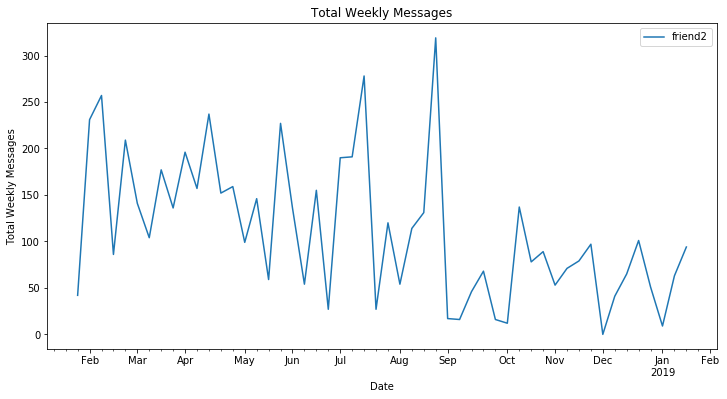

In [198]:
all_msg = pd.Series(all_msg, name="friend2")
all_msg.resample('W').sum().plot(figsize=(12,6))
plt.legend()
plt.title("Total Weekly Messages")
plt.xlabel("Date")
plt.ylabel("Total Weekly Messages")
plt.show()

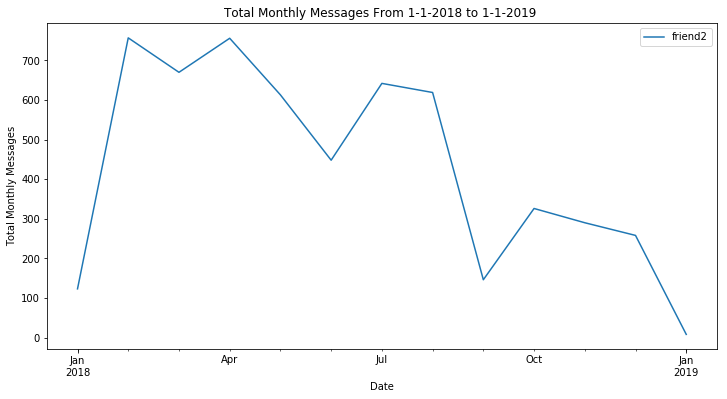

In [199]:
beg_date = '1-1-2018'
end_date = '1-1-2019'
all_msg[beg_date:end_date].resample('M').sum().plot(figsize=(12,6))
plt.title("Total Monthly Messages From {} to {} ".format(beg_date, end_date))
plt.xlabel("Date")
plt.ylabel("Total Monthly Messages")
plt.legend()
plt.show()

## Part 3: Moar friendship!!! 

(20 min) 

Wordcount

Sentiment

Emojis 

In [188]:
for msg in data['messages']: 
    body = msg['content']
    msg['wc'] = len(body.split())
    msg['senti'] = TextBlob(body).sentiment.polarity
    # filter out neutral 
    if msg['senti'] == 0 : 
        msg['senti'] = None
    sentence = codecs.escape_decode(body.encode('unicode-escape'))[0].decode('utf-8')
    msg['emoji']= du.find_emoji(sentence.split())

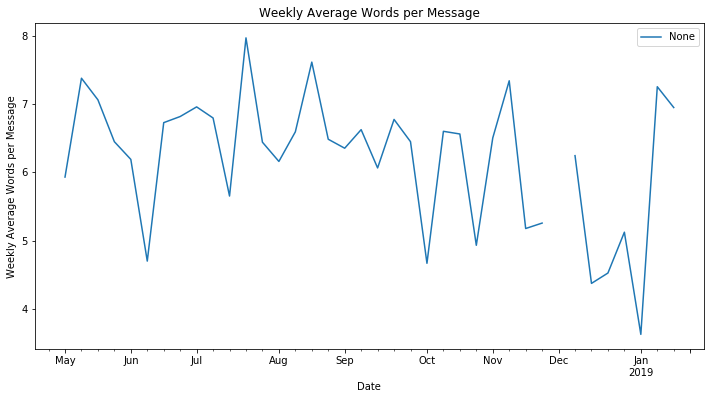

In [200]:
# Word count 
wc_dict = du.construct_time_count(data['messages'], 'wc')
wc_series = pd.Series(wc_dict, name="word_count")
av_wc_series = wc_series.divide(all_msg)
av_wc_series['5-1-2018':].resample("W").mean().plot(figsize=(12,6))
plt.legend()
plt.title("Weekly Average Words per Message")
plt.xlabel("Date")
plt.ylabel("Weekly Average Words per Message")
plt.show()

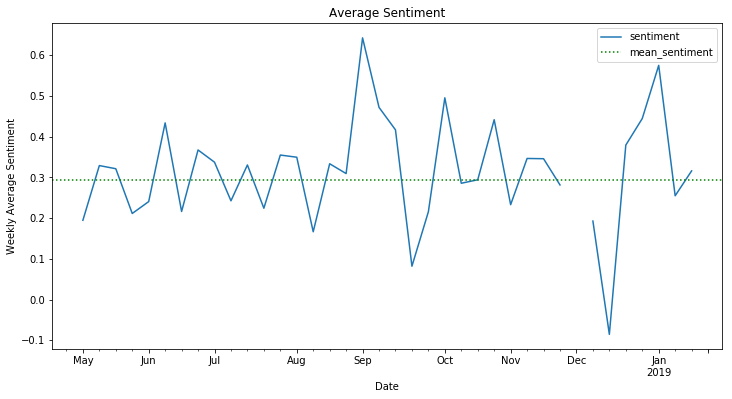

In [190]:
# sentiment
senti_dict = du.construct_time_avg(data['messages'], 'senti')
senti_series = pd.Series(senti_dict, name="sentiment")
senti_series['5-1-2018':].resample("W").mean().plot(figsize=(12,6))
plt.axhline(np.mean(senti_series['5-1-2018':]), label ='mean_sentiment', c='g', linestyle=':')
plt.legend()
plt.title("Average Sentiment")
plt.xlabel("Date")
plt.ylabel("Weekly Average Sentiment")
plt.show()

In [191]:
# emoji
all_emoji_counter = Counter() 
my_emoji_counter = Counter() 
friend_emoji_counter = Counter() 
for msg in data['messages']: 
    if len(msg['emoji']) > 0: 
        all_emoji_counter.update(msg['emoji'])
        if msg['sender_name'] == my_name: 
            my_emoji_counter.update(msg['emoji'])
        else: 
            friend_emoji_counter.update(msg['emoji'])

In [194]:
all_emoji_counter.most_common(10)

[('😞', 14),
 ('😭', 12),
 ('😉', 11),
 ('😂', 9),
 ('😀', 6),
 ('😛', 6),
 ('😮', 4),
 ('👌🏾', 3),
 ('😎', 2),
 ('😏', 1)]

## Part 4 Aggregate

(5 minutes) 

1. Top friends over time

In [46]:
direct_conversations = []  
for filename in os.listdir(root_dir):
    if not filename.startswith('.'): 
        with open(root_dir + filename + '/message.json') as f:
            data = json.load(f)
            num_part = len(data['participants'])
            # filtering by direct conversations
            if num_part == 2: 
                direct_conversations.append(data)

In [ ]:
# Top friends over time
messages_cnt = Counter()
for data in direct_conversations: 
    people = data['participants']
    for p in people: 
        if p['name'] != my_name: 
            person = p['name']
    num_messages = len(data['messages'])
    messages_cnt[person] = num_messages
    
    #find earliest 
    timestamp = data['messages'][0]['timestamp_ms']
    year = time.gmtime(int(timestamp/1000)).tm_year

In [ ]:
messages_cnt.most_common(20)

## Part 5: Design your own feature

Response time?

Coversation initiation?

In [61]:
# your code here